In [86]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [ ]:
holidays_events = pd.read_csv('Data/holidays_events.csv')
oil = pd.read_csv('Data/oil.csv')
stores = pd.read_csv('Data/stores.csv')
test = pd.read_csv('Data/test.csv')
train = pd.read_csv('Data/train.csv')
transactions = pd.read_csv('Data/transactions.csv')

In [ ]:
holidays_events["date"] = pd.to_datetime(holidays_events.date)
oil["date"] = pd.to_datetime(oil.date)
test["date"] = pd.to_datetime(test.date)
train["date"] = pd.to_datetime(train.date)
transactions["date"] = pd.to_datetime(transactions.date)

In [ ]:
oil['dcoilwtico'].fillna(np.nanmedian(oil.dcoilwtico), inplace = True)
oil.head(3)

In [ ]:
stores.head(3)

In [ ]:
train.head(3)

In [ ]:
test.head(3)

In [ ]:
transactions.head(3)

In [ ]:
#Relation of features of train and oil dataframes with sales 
plt.figure(figsize=(12, 12))
train_oil = pd.merge(train, oil, how='left')
sns.heatmap(train_oil.corr(), annot=True)
plt.plot

In [ ]:
#Is there co-relation of store_nbr with each other w.r.t sales
a = train[["store_nbr", "sales"]]
a["ind"] = 1
a["ind"] = a.groupby("store_nbr").ind.cumsum().values
a = pd.pivot(a, index = "ind", columns = "store_nbr", values = "sales").corr()
plt.figure(figsize=(20, 20))
sns.heatmap(a,
        annot=True,
        fmt='.1f',
        cmap='coolwarm',
        square=True,
        linewidths=1,
        cbar=False)
plt.title("Correlations among stores",fontsize = 20)
plt.show()

In [ ]:
train.shape

In [ ]:
train = train[~((train.store_nbr == 52) & (train.date < "2017-04-20"))]
train = train[~((train.store_nbr == 22) & (train.date < "2015-10-09"))]
train = train[~((train.store_nbr == 42) & (train.date < "2015-08-21"))]
train = train[~((train.store_nbr == 21) & (train.date < "2015-07-24"))]
train = train[~((train.store_nbr == 29) & (train.date < "2015-03-20"))]
train = train[~((train.store_nbr == 20) & (train.date < "2015-02-13"))]
train = train[~((train.store_nbr == 53) & (train.date < "2014-05-29"))]
train = train[~((train.store_nbr == 36) & (train.date < "2013-05-09"))]
train.shape

In [ ]:
# Stores which never sold products of particular family type.
sales_dependednt_on_family = train.groupby(["store_nbr", "family"]).sales.sum().reset_index().sort_values(["family","store_nbr"])
sales_dependednt_on_family = sales_dependednt_on_family[sales_dependednt_on_family.sales == 0]
sales_dependednt_on_family

In [ ]:
#Remove the entries from train where sales for a family type will always be zero, as calculated above
outer_join = train.merge(sales_dependednt_on_family.drop("sales",axis = 1), how = 'outer', indicator = True)
train = outer_join[~(outer_join._merge == 'both')].drop('_merge', axis = 1)
del outer_join
train.shape

In [ ]:
#If we need to predict sales of product 'A' by store '1' when '1' never sold it, it will automatically return 0. 
zero_prediction = []
for i in range(0,len(sales_dependednt_on_family)):
    zero_prediction.append(
        pd.DataFrame({
            "date":pd.date_range("2017-08-16", "2017-08-31").tolist(),
            "store_nbr":sales_dependednt_on_family.store_nbr.iloc[i],
            "family":sales_dependednt_on_family.family.iloc[i],
            "sales":0
        })
    )
zero_prediction = pd.concat(zero_prediction)
del sales_dependednt_on_family
zero_prediction

In [ ]:
# Product from which family type is sold the most.
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.figure(figsize=(20, 20))
train_family = train.set_index("date").groupby("family").resample("D").sales.sum().reset_index()
grp_by = train_family.groupby('family')['sales'].sum().reset_index()
plt.barh(grp_by['family'],grp_by['sales'])
plt.show()

In [ ]:
#Merged train and store and added a new column - 'year'
train_sales = pd.merge(train, stores)
train_sales["store_nbr"] = train_sales["store_nbr"].astype("int8")
train_sales["year"] = (train_sales.date.dt.year).astype('Int64', errors='ignore')
train_sales.head(2)

In [ ]:
sales_perCity_perYr = train_sales.groupby(["city", "year"]).sales.mean().reset_index()

In [ ]:
cities = set(sales_perCity_perYr['city'])
plt.figure(figsize=(12, 12))

for city in cities:
     selected_data = sales_perCity_perYr.loc[sales_perCity_perYr['city'] == city]
     plt.plot(selected_data['year'], selected_data['sales'], label=city)

plt.xticks([2013, 2014, 2015, 2016, 2017])
plt.grid()
plt.legend()
plt.show()

In [ ]:
holidays_events.head(3)

In [ ]:
holidays_events.shape

In [ ]:
holidays_events['type'].unique()

In [ ]:
# Transferred Holidays - A holiday reschedules to some other day
tr1 = holidays_events[(holidays_events.type == "Holiday") & (holidays_events.transferred == True)].drop("transferred", axis = 1).reset_index(drop = True)
tr2 = holidays_events[(holidays_events.type == "Transfer")].drop("transferred", axis = 1).reset_index(drop = True)
# So transfered_holidays -> when people were actually getting holiday with proper details.
transfered_holidays = tr1[['type', 'locale', 'locale_name', 'description']]
transfered_holidays['date'] = tr2['date']
transfered_holidays.head(3)

In [ ]:
holidays = holidays_events[(holidays_events['transferred'] == False) & (holidays_events['type'] != "Transfer")].drop("transferred", axis = 1)
holidays = holidays.append(transfered_holidays).reset_index(drop = True)
holidays.head(3)

In [ ]:
holidays["description"] = holidays["description"].str.replace("-", "").str.replace("+", "").str.replace('\d+', '')
holidays["type"] = np.where(holidays["type"] == "Additional", "Holiday", holidays["type"])

In [ ]:
holidays["description"] = holidays["description"].str.replace("Puente ", "")
holidays["type"] = np.where(holidays["type"] == "Bridge", "Holiday", holidays["type"])

In [ ]:
holidays["type"].unique()

In [ ]:
work_day = holidays[holidays.type == "Work Day"]  
holidays = holidays[holidays.type != "Work Day"]  

In [ ]:
events = holidays[holidays.type == "Event"].drop(["type", "locale", "locale_name"], axis = 1).rename({"description":"events"}, axis = 1)
holidays = holidays[holidays.type != "Event"].drop("type", axis = 1)
events.head(3)

In [ ]:
holidays.head(2)

In [ ]:
holidays["locale"].unique()

In [ ]:
local = holidays[holidays.locale == "Local"].rename({"description":"holiday_local", "locale_name":"city"}, axis = 1).drop("locale", axis = 1).drop_duplicates()
local.head(3)

In [ ]:
regional = holidays[holidays['locale'] == "Regional"].rename({"locale_name":"state", "description":"holiday_regional"}, axis = 1).drop("locale", axis = 1).drop_duplicates()
regional.head(3)

In [ ]:
national = holidays[holidays.locale == "National"].rename({"description":"holiday_national"}, axis = 1).drop(["locale", "locale_name"], axis = 1).drop_duplicates()
national.head(3)

In [ ]:
print(train.shape)
print(test.shape)

In [ ]:
df = pd.merge(train.append(test), stores)
df["store_nbr"] = df["store_nbr"].astype("int8")
df.head(3)

In [ ]:
df = pd.merge(df, national, how = "left")
df = pd.merge(df, regional, how = "left", on = ["date", "state"])
df = pd.merge(df, local, how = "left", on = ["date", "city"])

In [ ]:
df = pd.merge(df, work_day[["date", "type"]].rename({"type":"IsWorkDay"}, axis = 1),how = "left")

In [ ]:
df.head(3)

In [ ]:
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = df.select_dtypes(["category", "object"]).columns.tolist()
    #dummy_na : If true, it will create new column when nan = True
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    df.columns = df.columns.str.replace(" ", "_")
    return df, df.columns.tolist()

In [ ]:
events, events_cat = one_hot_encoder(events, nan_as_category=False)

In [ ]:
events[events['date'].duplicated(keep=False)]

In [ ]:
#Because of 2016.05.08, there were two events. pd.dummied would have created duplicate entries, so here marking 2nd one as True as well
events["events_Dia_de_la_Madre"] = np.where(events.date == "2016-05-08", 1,events["events_Dia_de_la_Madre"])
events = events.drop(239)

In [ ]:
df = df.merge(events, how = 'left')

In [ ]:
df.head(2)

In [ ]:
# Filling Null values
df[events_cat] = df[events_cat].fillna(0)

# Adding New features as binarised holiday types
df["holiday_national_binary"] = np.where(df.holiday_national.notnull(), 1, 0)
df["holiday_local_binary"] = np.where(df.holiday_local.notnull(), 1, 0)
df["holiday_regional_binary"] = np.where(df.holiday_regional.notnull(), 1, 0)
df.head(3)

In [ ]:
#Converting holiday types to binaries
df["national_independence"] = np.where(df.holiday_national.isin(['Batalla de Pichincha','Independencia de Cuenca','Independencia de Guayaquil','Independencia de Guayaquil','Primer Grito de Independencia']), 1, 0)
df["local_cantonizacio"] = np.where(df.holiday_local.str.contains("Cantonizacio"), 1, 0)
df["local_fundacion"] = np.where(df.holiday_local.str.contains("Fundacion"), 1, 0)
df["local_independencia"] = np.where(df.holiday_local.str.contains("Independencia"), 1, 0)

In [ ]:
holidays, holidays_cat = one_hot_encoder(df[["holiday_national","holiday_regional","holiday_local"]], nan_as_category=False)

In [ ]:
df = pd.concat([df.drop(["holiday_national","holiday_regional","holiday_local"], axis = 1), holidays], axis = 1)

In [ ]:
# Ensured that all dummies are int8 type
he_cols = df.columns[df.columns.str.startswith("events")].tolist() + df.columns[df.columns.str.startswith("holiday")].tolist() + df.columns[df.columns.str.startswith("national")].tolist()+ df.columns[df.columns.str.startswith("local")].tolist()
df[he_cols] = df[he_cols].astype("int8")

In [ ]:
# Ensuring category type of certain features
df[["family", "city", "state", "type"]] = df[["family", "city", "state", "type"]].astype("category")

In [ ]:
del holidays, holidays_cat, work_day, local, regional, national, events, events_cat, transfered_holidays, tr1, tr2, he_cols

In [ ]:
df.head()

In [ ]:
#Fetching info from data
def create_date_features(df):
    df['month'] = df.date.dt.month.astype("int8")
    df['day_of_month'] = df.date.dt.day.astype("int8")  
    df['day_of_week'] = (df.date.dt.dayofweek + 1).astype("int8")
    df['year'] = df.date.dt.year.astype("int32")
    df["is_wknd"] = (df.date.dt.weekday // 4).astype("int8")
    df['is_month_start'] = df.date.dt.is_month_start.astype("int8")
    df['is_month_end'] = df.date.dt.is_month_end.astype("int8")
    df['is_year_start'] = df.date.dt.is_year_start.astype("int8")
    df['is_year_end'] = df.date.dt.is_year_end.astype("int8")
    # 0: Winter - 1: Spring - 2: Summer - 3: Fall
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    df["season"] = pd.Series(np.where(df.month.isin([9, 10, 11]), 3, df["season"])).astype("int8")
    df['day_of_year'] = df.date.dt.dayofyear.astype("int16")
#     df['week_of_month'] = (df.date.apply(lambda d: (d.day-1) // 7 + 1)).astype("int8")
#     df['week_of_year'] = (df.date.dt.weekofyear).astype("int8")
#     df["quarter"] = df.date.dt.quarter.astype("int8")
#     df["quarter"] = df.date.dt.quarter.astype("int8")
#     df['is_quarter_start'] = df.date.dt.is_quarter_start.astype("int8")
#     df['is_quarter_end'] = df.date.dt.is_quarter_end.astype("int8")
    return df
df = create_date_features(df)

In [ ]:
df["workday"] = np.where((df.holiday_national_binary == 1) | (df.holiday_local_binary==1) | (df.holiday_regional_binary==1) | (df['day_of_week'].isin([6,7])), 0, 1)
df.drop("IsWorkDay", axis = 1, inplace = True)

In [ ]:
df["wageday"] = pd.Series(np.where((df['is_month_end'] == 1) | (df["day_of_month"] == 15), 1, 0)).astype("int8")

In [ ]:
df.head(2)

As there was Earthquack April 16, 2016, so looking into mean data of March, Apr-May and June too see if there is drop/hike in sales that could act as outlier.

In [ ]:
df[(df['month'].isin([4,5]))].groupby(["year"]).sales.mean()

In [ ]:
pd.pivot_table(df[(df['month'].isin([3]))], index="year", columns="family", values="sales", aggfunc="mean")

In [ ]:
pd.pivot_table(df[(df['month'].isin([4,5]))], index="year", columns="family", values="sales", aggfunc="mean")

In [ ]:
pd.pivot_table(df[(df['month'].isin([6]))], index="year", columns="family", values="sales", aggfunc="mean")

No major drop or hike

In [ ]:
df.to_csv('Data/final_data.csv', index=False)

In [9]:
df = pd.read_csv('Data/final_data.csv')

In [10]:
df.head(2)

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,year,is_wknd,is_month_start,is_month_end,is_year_start,is_year_end,season,day_of_year,workday,wageday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,2013,0,1,0,1,0,0,1,0,0
1,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13,...,2013,0,0,0,0,0,0,2,1,0


Stationarity Check

In [11]:
# df_sales = df[(df['date'] >='2016-01-01') &  (df['date'] <= "2016-12-31")]
yr_mnth_sales = df.groupby(['year','month'])['sales'].sum().reset_index()
yr_mnth_sales.head()

,year,month,sales
0,2013,1,1.032762e+07
1,2013,2,9.658960e+06
2,2013,3,1.142850e+07
3,2013,4,1.099346e+07
4,2013,5,1.159770e+07


In [12]:
df = df.set_index('date')

In [13]:
def test_stationarity(dataframe):
    #Rolling Mean and Rolling Std
    plt.figure(figsize=(16,16))
    rollMean = dataframe.rolling(12).mean()
    rollStd = dataframe.rolling(12).std()
    orignal = plt.plot(dataframe['sales'], color = "blue", label = "Original")
    mean = plt.plot(rollMean['sales'], color = "red", label = "Rolling Mean")
    std = plt.plot(rollStd['sales'], color = "green", label = "Rolling Std")
    plt.legend(loc = 'best')
    plt.title("Rolling Stationarity Test")
    plt.show()
    
    #Dicky Fuller Test
    df_test = adfuller(dataframe['sales'], autolag='AIC')
    df_output = pd.Series(df_test[0:4], index = ['Test Stats', 'p-value', 'Lags Used', 'No of observations'])
    for key in df_test[4]:
        df_output[f'Critical Value {key}'] = df_test[4][key]
    print(df_output)
    return rollMean

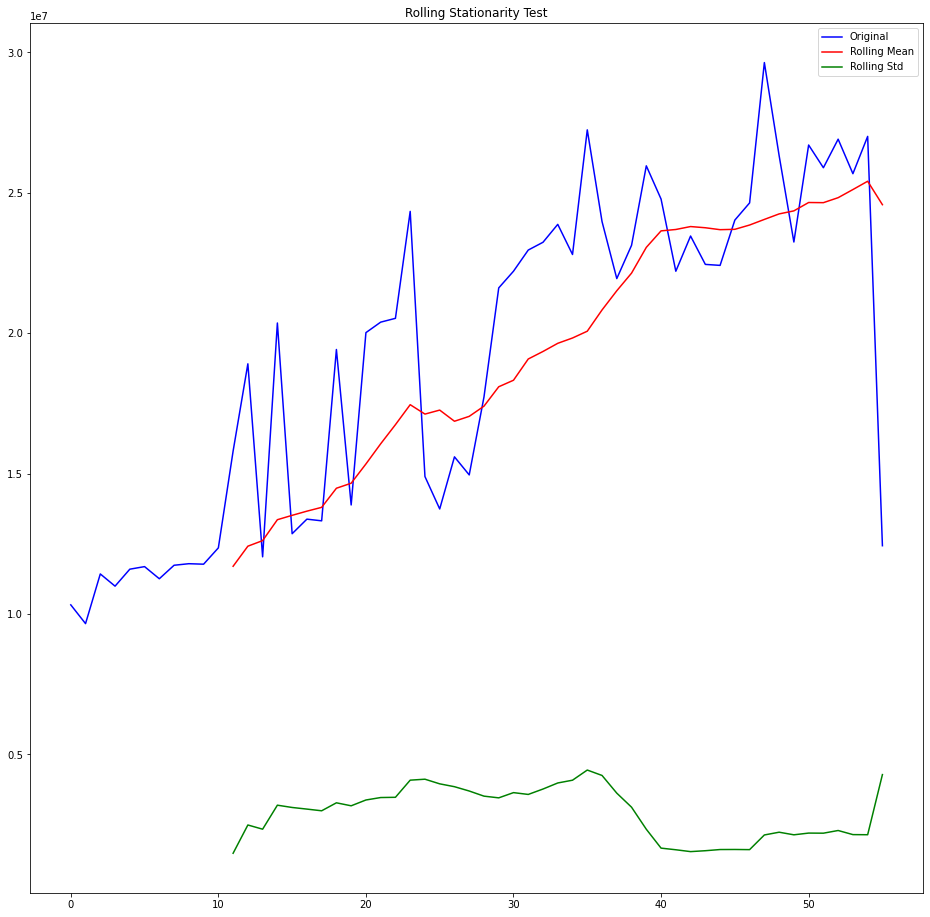

Test Stats            -2.045287
p-value                0.267076
Lags Used              1.000000
No of observations    54.000000
Critical Value 1%     -3.557709
Critical Value 5%     -2.916770
Critical Value 10%    -2.596222
dtype: float64


In [14]:
roll_mean_orig = test_stationarity(yr_mnth_sales)

In [15]:
log_transform = yr_mnth_sales
log_transform['sales'] = np.log(yr_mnth_sales['sales'])
log_transform.head()

,year,month,sales
0,2013,1,16.150333
1,2013,2,16.083397
2,2013,3,16.251621
3,2013,4,16.212812
4,2013,5,16.266318


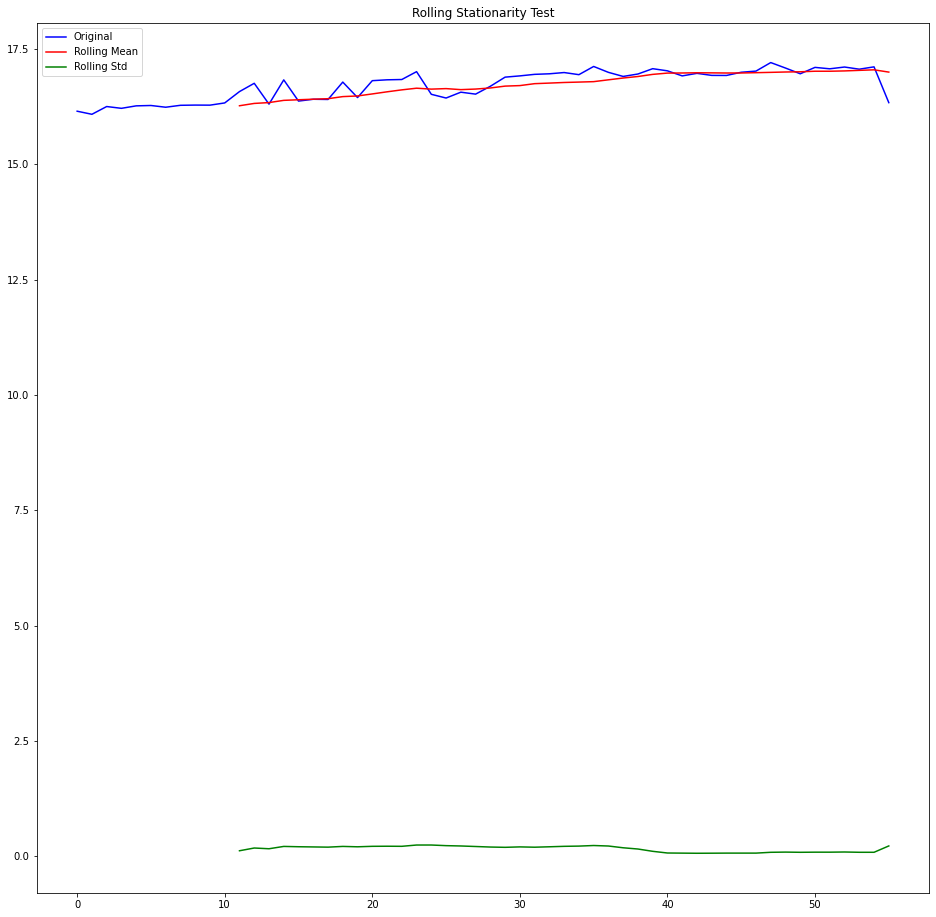

Test Stats            -2.185525
p-value                0.211541
Lags Used              1.000000
No of observations    54.000000
Critical Value 1%     -3.557709
Critical Value 5%     -2.916770
Critical Value 10%    -2.596222
dtype: float64


In [16]:
roll_mean_log = test_stationarity(log_transform)

In [18]:
log_ma_diff = log_transform['sales'] - roll_mean_log['sales']
log_ma_diff.dropna(inplace = True)
log_ma_diff.head(2)

11    0.307093
12    0.436251
Name: sales, dtype: float64

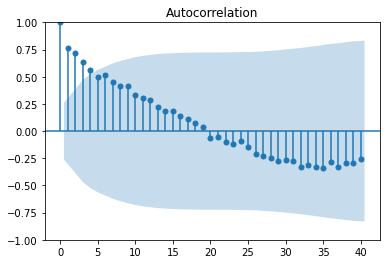

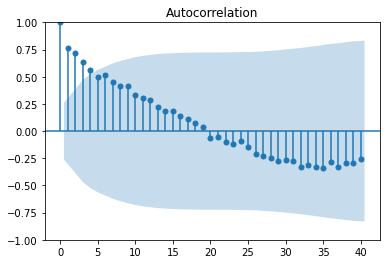

In [19]:
plot_acf(log_transform['sales'], lags = 40)

So as the curve crosses the critical point line near 3.5-4, lets experiment with q = 3,4

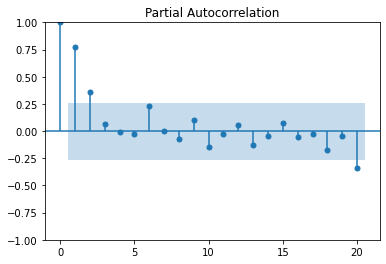

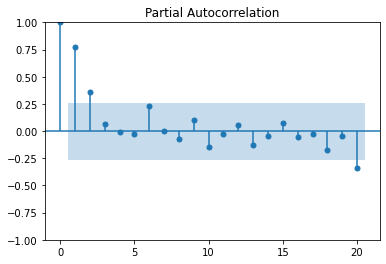

In [21]:
plot_pacf(log_transform['sales'], lags = 20)

As the bars cross critical point 3 times, lets experiment with p = 3,4

# Train- Test splitting

In [64]:
percent_70 = round(len(log_transform) *0.7)

In [70]:
train = log_transform[: percent_70]
test = log_transform[percent_70:]
y_actual = test['sales']
test.drop('sales', axis = 1, inplace = True)
test.reset_index(inplace = True)

In [71]:
print(train.tail())
print(test.head())

    year  month      sales
34  2015     11  16.942488
35  2015     12  17.120343
36  2016      1  16.992639
37  2016      2  16.904160
38  2016      3  16.956718
   index  year  month
0     39  2016      4
1     40  2016      5
2     41  2016      6
3     42  2016      7
4     43  2016      8


In [72]:
cols = train.columns

In [73]:
for col in cols:
    model = ARIMA(log_transform[col], order = (3, 3 ,2))

In [74]:
model = model.fit()

In [75]:
y_pred = model.predict(start = test.index[0], end = test.index[-1])
y_pred

0      0.000000
1     32.300666
2     13.291271
3     16.654999
4     16.321246
5     16.296255
6     16.314335
7     16.206881
8     16.257300
9     16.261011
10    16.282641
11    16.329745
12    16.578598
13    16.908532
14    16.576914
15    16.689701
16    16.469620
Name: predicted_mean, dtype: float64

In [78]:
y_actual = y_actual.reset_index(drop = True)

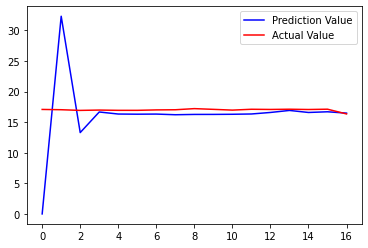

In [80]:
plt.plot(y_pred, color='blue', label='Prediction Value')
plt.plot(y_actual, color='red', label = 'Actual Value')
plt.legend(loc = 'best')
plt.show()

In [85]:
np.sqrt(mean_squared_error(y_pred, y_actual))

5.653004301518345

In [87]:
model.s

ValueError: continuous is not supported